Car Price Prediction Using Machine Learning
Problem Statement

The automotive industry and online vehicle resale platforms increasingly rely on data-driven systems to estimate fair market prices of used cars. Traditional manual pricing often leads to inconsistent valuation, pricing bias, and limited transparency. Buyers and sellers require an automated solution that can accurately evaluate a vehicle’s worth based on its specifications, condition and usage history.

This project aims to develop a machine learning based predictive system that estimates the market price of a car using historical vehicle listings. By analyzing multiple features such as brand, manufacturing year, engine capacity, fuel type, mileage, transmission and vehicle condition, the model provides fair pricing recommendations that can be used by car dealerships, online selling platforms and individual buyers.

Business Use Cases

Used-car market platforms (Cars24 / OLX / CarDekho)

Automobile resellers

Dealership pricing decision support

Insurance valuation

Loan approval and risk assessment

Automotive finance companies

Project Objective

Build a regression model capable of predicting the market price of a car based on its technical specifications and usage data using modern machine learning techniques.

Dataset

Car Price Prediction Dataset (2025) – Kaggle (Ali Hussain)

It contains real-world car listing data including:

Brand

Model

Year

Engine Size

Fuel Type

Transmission

Condition

Mileage

Price (target)

Project Workflow

Data loading & exploratory analysis

Handling missing values & duplicates

Feature engineering (Car Age, High Mileage etc.)

Encoding categorical variables

Building ML pipelines with preprocessing

Training multiple regression models

Hyperparameter tuning (Random Forest)

Model evaluation using RMSE, MAE, R²

Feature importance analysis

Saving model for deployment

Imports & Data Loading

In [1]:
# 1. IMPORTS
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

import warnings
warnings.filterwarnings("ignore")

# 2. LOAD DATA
# Dataset is stored in the "data" folder inside the project directory
df = pd.read_csv("data/car_price_prediction_.csv")

# quick peek
df.head()


,Car ID,Brand,Year,Engine Size,Fuel Type,Transmission,Mileage,Condition,Price,Model
0,1,Tesla,2016,2.3,Petrol,Manual,114832,New,26613.92,Model X
1,2,BMW,2018,4.4,Electric,Manual,143190,Used,14679.61,5 Series
2,3,Audi,2013,4.5,Electric,Manual,181601,New,44402.61,A4
3,4,Tesla,2011,4.1,Diesel,Automatic,68682,New,86374.33,Model Y
4,5,Ford,2009,2.6,Diesel,Manual,223009,Like New,73577.10,Mustang


In [2]:
print("Shape (rows, columns):", df.shape)
print("\nColumns:\n", df.columns)

print("\nInfo:")
df.info()

print("\nSummary statistics (numeric columns):")
df.describe()


Shape (rows, columns): (2500, 10)

Columns:
 Index(['Car ID', 'Brand', 'Year', 'Engine Size', 'Fuel Type', 'Transmission',
       'Mileage', 'Condition', 'Price', 'Model'],
      dtype='object')

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Car ID        2500 non-null   int64  
 1   Brand         2500 non-null   object 
 2   Year          2500 non-null   int64  
 3   Engine Size   2500 non-null   float64
 4   Fuel Type     2500 non-null   object 
 5   Transmission  2500 non-null   object 
 6   Mileage       2500 non-null   int64  
 7   Condition     2500 non-null   object 
 8   Price         2500 non-null   float64
 9   Model         2500 non-null   object 
dtypes: float64(2), int64(3), object(5)
memory usage: 195.4+ KB

Summary statistics (numeric columns):


,Car ID,Year,Engine Size,Mileage,Price
count,2500.00000,2500.0000,2500.000000,2500.000000,2500.000000
mean,1250.50000,2011.6268,3.465240,149749.844800,52638.022532
std,721.83216,6.9917,1.432053,87919.952034,27295.833455
min,1.00000,2000.0000,1.000000,15.000000,5011.270000
25%,625.75000,2005.0000,2.200000,71831.500000,28908.485000
50%,1250.50000,2012.0000,3.400000,149085.000000,53485.240000
75%,1875.25000,2018.0000,4.700000,225990.500000,75838.532500
max,2500.00000,2023.0000,6.000000,299967.000000,99982.590000


Missing Values, Duplicates & Basic Cleaning

In [3]:
# check missing values
df.isna().sum()


Car ID          0
Brand           0
Year            0
Engine Size     0
Fuel Type       0
Transmission    0
Mileage         0
Condition       0
Price           0
Model           0
dtype: int64

In [4]:
# drop exact duplicate rows if any
before = df.shape[0]
df = df.drop_duplicates()
after = df.shape[0]
print(f"Removed {before - after} duplicate rows")

# optional: drop rows with missing target
df = df.dropna(subset=["Price"])

# if there are very few missing in other columns, we can drop them
# (or you can choose to impute later in the pipeline)
df = df.dropna()
print("Shape after dropping NA:", df.shape)


Removed 0 duplicate rows
Shape after dropping NA: (2500, 10)


Exploratory Data Analysis (EDA)
Target Variable Distribution

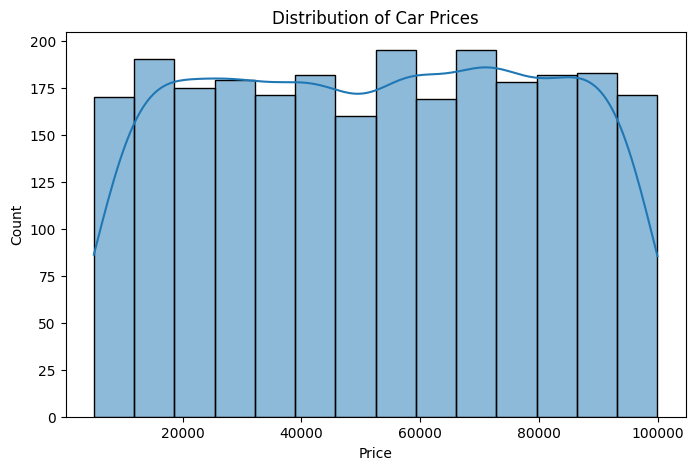

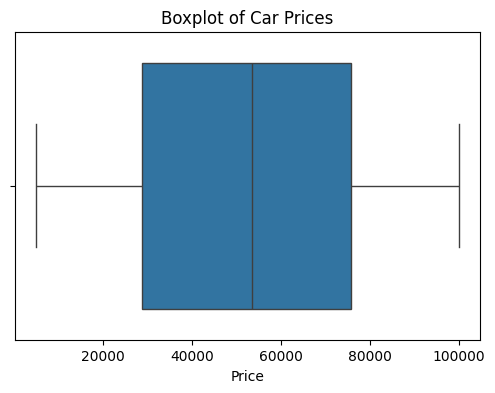

In [5]:
plt.figure(figsize=(8,5))
sns.histplot(df["Price"], kde=True)
plt.title("Distribution of Car Prices")
plt.xlabel("Price")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(6,4))
sns.boxplot(x=df["Price"])
plt.title("Boxplot of Car Prices")
plt.show()


Numeric Features vs Price

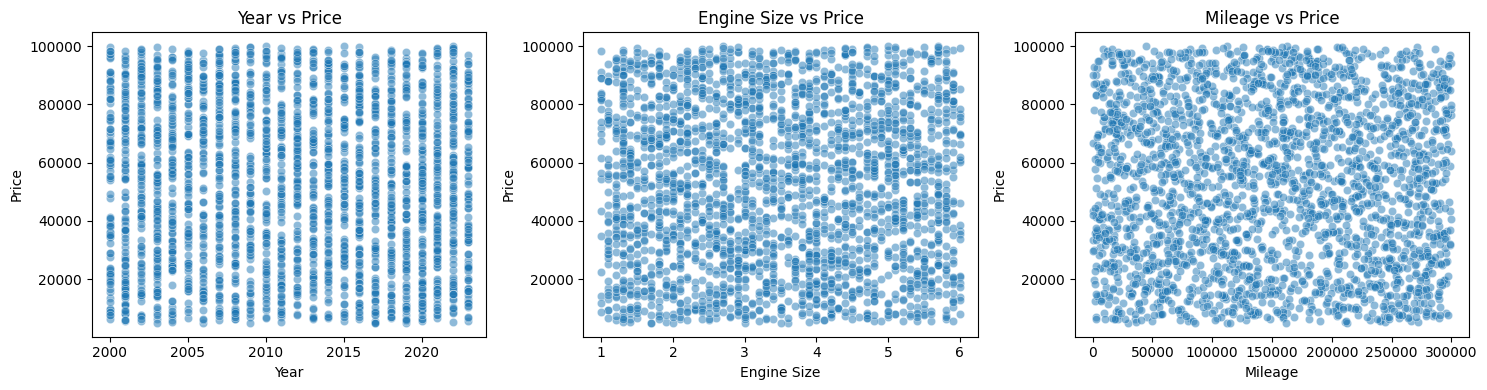

In [6]:
numeric_cols = ["Year", "Engine Size", "Mileage"]

plt.figure(figsize=(15,4))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(1, 3, i)
    sns.scatterplot(data=df, x=col, y="Price", alpha=0.5)
    plt.title(f"{col} vs Price")
plt.tight_layout()
plt.show()


Categorical Features vs Price

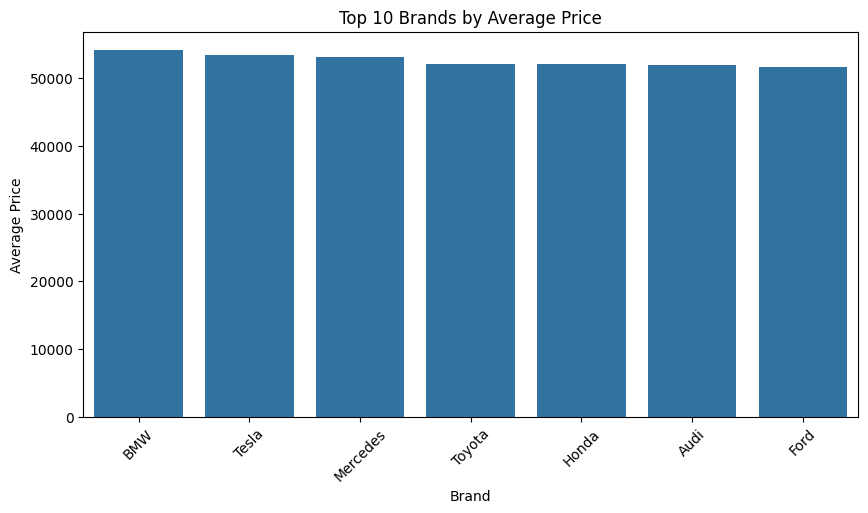

In [7]:
plt.figure(figsize=(10,5))
brand_price = df.groupby("Brand")["Price"].mean().sort_values(ascending=False).head(10)
sns.barplot(x=brand_price.index, y=brand_price.values)
plt.xticks(rotation=45)
plt.title("Top 10 Brands by Average Price")
plt.ylabel("Average Price")
plt.show()


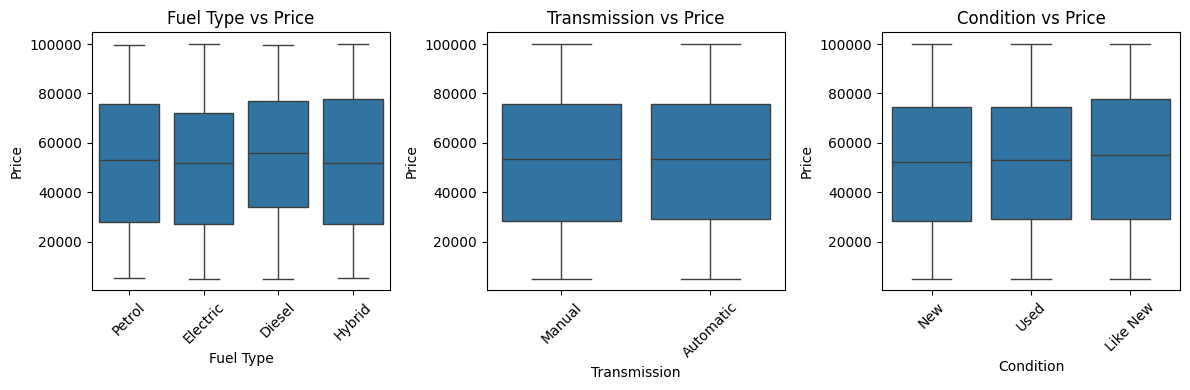

In [8]:
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
sns.boxplot(data=df, x="Fuel Type", y="Price")
plt.xticks(rotation=45)
plt.title("Fuel Type vs Price")

plt.subplot(1,3,2)
sns.boxplot(data=df, x="Transmission", y="Price")
plt.xticks(rotation=45)
plt.title("Transmission vs Price")

plt.subplot(1,3,3)
sns.boxplot(data=df, x="Condition", y="Price")
plt.xticks(rotation=45)
plt.title("Condition vs Price")

plt.tight_layout()
plt.show()


Feature Engineering

In [9]:
# create car age feature
reference_year = df["Year"].max()   # e.g. 2023 in this dataset
df["Car_Age"] = reference_year - df["Year"]

# optional: drop Year if you only want age
# (we’ll keep both for now)
df[["Year", "Car_Age"]].head()


,Year,Car_Age
0,2016,7
1,2018,5
2,2013,10
3,2011,12
4,2009,14


In [10]:
# simple high mileage flag (1 if in top 25% mileage)
mileage_q75 = df["Mileage"].quantile(0.75)
df["High_Mileage"] = (df["Mileage"] > mileage_q75).astype(int)

df[["Mileage", "High_Mileage"]].head()


,Mileage,High_Mileage
0,114832,0
1,143190,0
2,181601,0
3,68682,0
4,223009,0


Train–Test Split & Feature

In [11]:
# features and target
X = df.drop(columns=["Price", "Car ID"])  # Car ID not useful for prediction
y = df["Price"]

# identify numeric and categorical cols automatically
numeric_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X.select_dtypes(include=["object"]).columns.tolist()

print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)

# train–test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


Numeric features: ['Year', 'Engine Size', 'Mileage', 'Car_Age']
Categorical features: ['Brand', 'Fuel Type', 'Transmission', 'Condition', 'Model']


Preprocessing & ML Pipeline

In [12]:
# preprocessing for numeric and categorical features
numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)


In [13]:
def evaluate_regression_model(model, X_train, X_test, y_train, y_test):
    # train
    model.fit(X_train, y_train)

    # predict
    y_pred = model.predict(X_test)

    # metrics
    mae = mean_absolute_error(y_test, y_pred)

    # old sklearn does not support `squared` argument
    mse = mean_squared_error(y_test, y_pred)   # just this
    rmse = np.sqrt(mse)                        # manual RMSE

    r2 = r2_score(y_test, y_pred)

    print(f"Model: {type(model).__name__}")
    print(f"MAE : {mae:.2f}")
    print(f"MSE : {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R2  : {r2:.3f}")

    return {"MAE": mae, "MSE": mse, "RMSE": rmse, "R2": r2}


Regression Models (Baseline)

Linear Regression

In [14]:
linreg_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", LinearRegression())
])

linreg_results = evaluate_regression_model(
    linreg_pipeline, X_train, X_test, y_train, y_test
)


Model: Pipeline
MAE : 23877.14
MSE : 772529508.33
RMSE: 27794.42
R2  : -0.020


Random Forest Regressor

In [15]:
rf_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", RandomForestRegressor(
        n_estimators=200,
        random_state=42,
        n_jobs=-1
    ))
])

rf_results = evaluate_regression_model(
    rf_pipeline, X_train, X_test, y_train, y_test
)

Model: Pipeline
MAE : 24489.81
MSE : 808450565.29
RMSE: 28433.27
R2  : -0.067


 Gradient Boosting Regressor

In [16]:
gbr_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", GradientBoostingRegressor(random_state=42))
])

gbr_results = evaluate_regression_model(
    gbr_pipeline, X_train, X_test, y_train, y_test
)

Model: Pipeline
MAE : 23907.65
MSE : 785406827.25
RMSE: 28025.11
R2  : -0.037


In [17]:
# make a copy so original df is still available
df2 = df.copy()


In [18]:
TARGET_COL = "Price"

# keep cars between 50,000 and 5,00,000 (example filter, change if you want)
df2 = df2[df2[TARGET_COL] > 50000]
df2 = df2[df2[TARGET_COL] < 5000000]

print(df2[TARGET_COL].min(), df2[TARGET_COL].max())
print(df2.shape)


50000.1 99982.59
(1321, 12)


In [19]:
import numpy as np

# target (log-transformed price)
y = np.log1p(df2[TARGET_COL])          # log1p = log(1 + x), safer for small values

# features (drop target + ID column)
X = df2.drop(columns=[TARGET_COL, "Car ID"])


In [20]:
numeric_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X.select_dtypes(include=["object"]).columns.tolist()

print("Numeric:", numeric_features)
print("Categorical:", categorical_features)


Numeric: ['Year', 'Engine Size', 'Mileage', 'Car_Age']
Categorical: ['Brand', 'Fuel Type', 'Transmission', 'Condition', 'Model']


In [21]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(X_train.shape, X_test.shape)


(1056, 10) (265, 10)


In [22]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor2 = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)


In [23]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Linear Regression
linreg_pipe2 = Pipeline(steps=[
    ("preprocessor", preprocessor2),
    ("regressor", LinearRegression())
])

# Random Forest
rf_pipe2 = Pipeline(steps=[
    ("preprocessor", preprocessor2),
    ("regressor", RandomForestRegressor(
        n_estimators=200,
        random_state=42,
        n_jobs=-1
    ))
])

# Gradient Boosting
gbr_pipe2 = Pipeline(steps=[
    ("preprocessor", preprocessor2),
    ("regressor", GradientBoostingRegressor(random_state=42))
])

# use your existing evaluation function
linreg_results2 = evaluate_regression_model(linreg_pipe2, X_train, X_test, y_train, y_test)
rf_results2     = evaluate_regression_model(rf_pipe2,    X_train, X_test, y_train, y_test)
gbr_results2    = evaluate_regression_model(gbr_pipe2,   X_train, X_test, y_train, y_test)


Model: Pipeline
MAE : 0.17
MSE : 0.04
RMSE: 0.20
R2  : -0.042
Model: Pipeline
MAE : 0.17
MSE : 0.04
RMSE: 0.20
R2  : -0.055
Model: Pipeline
MAE : 0.17
MSE : 0.04
RMSE: 0.20
R2  : -0.042


In [24]:
print("Old Linear Regression (original Price):", linreg_results)
print("New Linear Regression (log Price):    ", linreg_results2)


Old Linear Regression (original Price): {'MAE': 23877.144627839236, 'MSE': 772529508.3257211, 'RMSE': 27794.41505636917, 'R2': -0.019769137569038975}
New Linear Regression (log Price):     {'MAE': 0.17206924602365037, 'MSE': 0.03930024042434151, 'RMSE': 0.19824288240524932, 'R2': -0.04171108211763053}


XGBoost on log-Price

In [25]:
import xgboost as xgb


evaluation function for original scale

XGBoost pipeline (with preprocessor2 and log target)

In [26]:
def evaluate_regression_model_manual_values(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred) ** 0.5  # <-- fixed
    r2 = r2_score(y_true, y_pred)

    print(f"MAE : {mae:,.2f}")
    print(f"RMSE: {rmse:,.2f}")
    print(f"R²  : {r2:,.4f}")

    return {"MAE": mae, "RMSE": rmse, "R2": r2}


Hyperparameter Tuning for Random Forest (log-Price)

In [27]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

rf_base = Pipeline(steps=[
    ("preprocessor", preprocessor2),
    ("regressor", RandomForestRegressor(random_state=42, n_jobs=-1))
])

param_grid = {
    "regressor__n_estimators": [100, 200, 300],
    "regressor__max_depth": [None, 10, 20],
    "regressor__min_samples_split": [2, 5],
    "regressor__min_samples_leaf": [1, 2],
}

grid_search = GridSearchCV(
    rf_base,
    param_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",  # RMSE in log space
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)  # still log1p target

print("Best params:", grid_search.best_params_)
print("Best CV RMSE (log scale):", -grid_search.best_score_)


Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best params: {'regressor__max_depth': 10, 'regressor__min_samples_leaf': 2, 'regressor__min_samples_split': 5, 'regressor__n_estimators': 300}
Best CV RMSE (log scale): 0.19739198973634958


Evaluate the tuned RF on original price scale

In [28]:
best_rf_model = grid_search.best_estimator_

# predictions in log1p space
y_pred_test_log = best_rf_model.predict(X_test)

# back to original Price
y_pred_test = np.expm1(y_pred_test_log)
y_true_test = np.expm1(y_test)

print("Tuned RandomForestRegressor performance (original Price):")
rf_tuned_results = evaluate_regression_model_manual_values(y_true_test, y_pred_test)


Tuned RandomForestRegressor performance (original Price):
MAE : 12,556.90
RMSE: 14,476.45
R²  : -0.0341


Feature Importance from tuned RF

In [29]:
# numeric features (as they are)
num_features_out = numeric_features

# categorical one-hot feature names
cat_encoder = best_rf_model.named_steps["preprocessor"] \
                           .named_transformers_["cat"] \
                           .named_steps["onehot"]

cat_features_out = cat_encoder.get_feature_names_out(categorical_features)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

all_feature_names = np.concatenate([num_features_out, cat_features_out])

rf_reg = best_rf_model.named_steps["regressor"]
importances = rf_reg.feature_importances_

feature_importance = pd.DataFrame({
    "feature": all_feature_names,
    "importance": importances
}).sort_values(by="importance", ascending=False)

feature_importance.head(20)


,feature,importance
2,Mileage,0.248652
1,Engine Size,0.178059
0,Year,0.073172
3,Car_Age,0.070496
19,Condition_Used,0.023454
11,Fuel Type_Diesel,0.020649
7,Brand_Honda,0.019641
12,Fuel Type_Electric,0.018755
13,Fuel Type_Hybrid,0.018701
14,Fuel Type_Petrol,0.018597


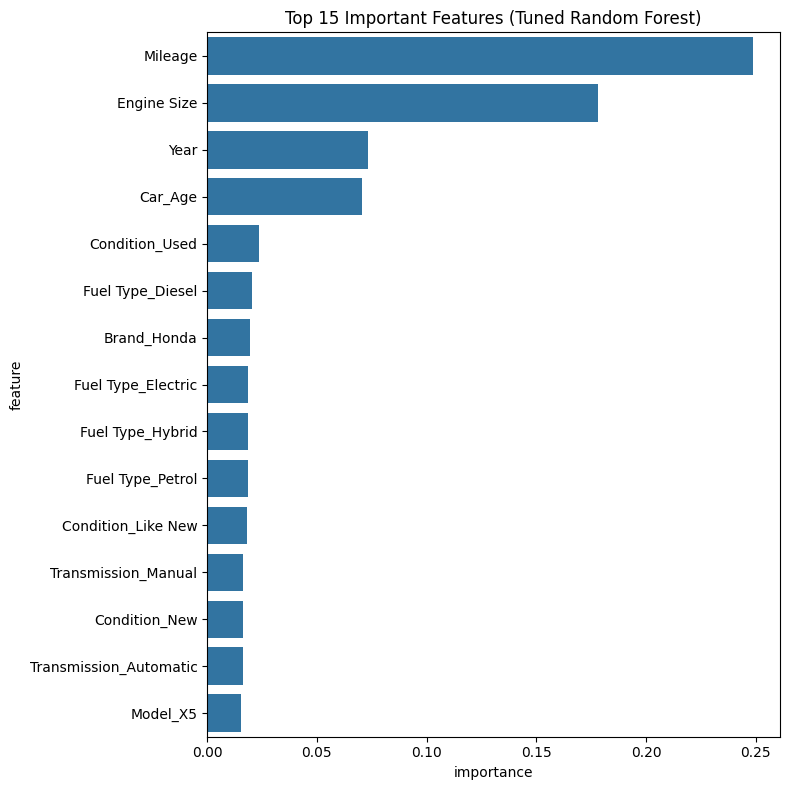

In [30]:
plt.figure(figsize=(8, 8))
sns.barplot(
    data=feature_importance.head(15),
    x="importance",
    y="feature"
)
plt.title("Top 15 Important Features (Tuned Random Forest)")
plt.tight_layout()
plt.show()


Save and Load Final Model

In [31]:
import joblib

joblib.dump(best_rf_model, "car_price_rf_model.joblib")
print("Model saved as car_price_rf_model.joblib")


Model saved as car_price_rf_model.joblib


In [32]:
loaded_model = joblib.load("car_price_rf_model.joblib")

# IMPORTANT: pass features in SAME form as training (no Price, has Car_Age etc.)
sample = X_test.iloc[[0]]        # keep as DataFrame
pred_price_log = loaded_model.predict(sample)   # log1p scale
pred_price = np.expm1(pred_price_log)          # back to original

print("Predicted price:", pred_price[0])


Predicted price: 71825.97449734366
